# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [7]:
%load_ext autoreload
%autoreload 2
from maddpg import MADDPG
import torch
from collections import deque
from matplotlib import pyplot as plt

In [11]:
UPDATE_NOISE_RATE = 2
def trainFunction(state_size, action_size, n_episodes=4000, num_agents = 2):
    magent = MADDPG(num_agents = num_agents, state_size = state_size, action_size= action_size,gamma=0.98, stop_noise=50000)
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []
    update = False
    for i_episode in range(1, n_episodes + 1):
        rewards = []
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations  # get the current state (for each agent)
        if i_episode%UPDATE_NOISE_RATE == 0:
            update = True
        # loop over steps
        while True:
            # select an action
            joint_actions = magent.act(states, update)
            update = False
            # take action in environment and set parameters to new values
            env_info = env.step(joint_actions)[brain_name]
            next_states = env_info.vector_observations
            rewards_v = env_info.rewards
            done_v = env_info.local_done
            # update and train agent with returned information
            magent.step(states, joint_actions, rewards_v, next_states, done_v)
            states = next_states
            rewards.append(rewards_v)
            if any(done_v):
                break

        # calculate episode reward as maximum of individually collected rewards of agents
        episode_reward = np.max(np.sum(np.array(rewards), axis=0))

        scores.append(episode_reward)  # save most recent score to overall score array
        scores_deque.append(episode_reward)  # save most recent score to running window of 100 last scores
        current_avg_score = np.mean(scores_deque)
        scores_avg.append(current_avg_score)  # save average of last 100 scores to average score array

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score), end="")

        # log average score every 200 episodes
        if i_episode % 200 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))

        # break and report success if environment is solved
        if np.mean(scores_deque) >= .5 and i_episode%200==0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode,
                                                                                         np.mean(scores_deque)))
            magent.save()
    return scores, scores_avg

In [ ]:
n_episodes = 2000
scores,scores_avg = trainFunction(state_size, action_size, n_episodes)

Episode 200	Average Score: 0.019
Episode 400	Average Score: 0.013
Episode 600	Average Score: 0.074
Episode 800	Average Score: 0.120
Episode 863	Average Score: 0.096

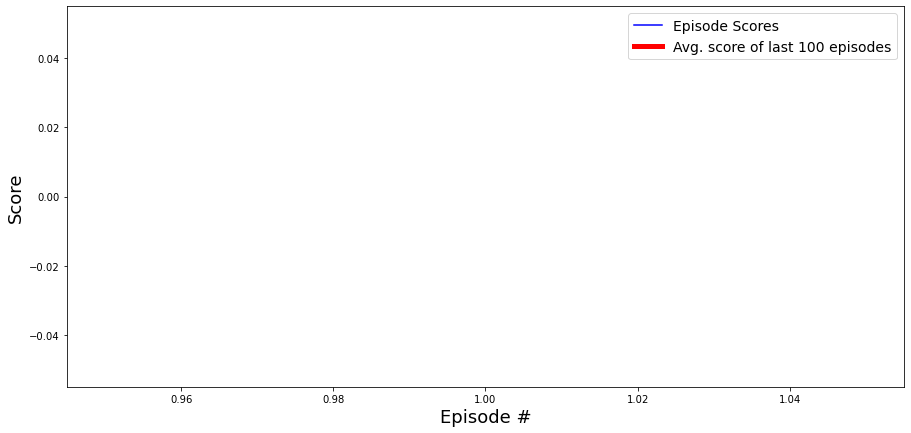

In [10]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'r',\
         linewidth=5,label='Avg. score of last 100 episodes')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.show()